<a href="https://colab.research.google.com/github/dnasywa/NutriScan/blob/main/capstone_RGB_model_and_recomendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset Preparation

## Overview

In [ ]:
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# dataset Info
base_dir = '/content/drive/MyDrive/bangkit/dataset_bilal/lettuce'
class_names = ['FN', '-N', '-P', '-K']

## Split

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

In [ ]:
train_dir = base_dir + "/train"
validation_dir = base_dir + "/validation"
test_dir = base_dir + "/test"

In [ ]:
# create the directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [ ]:
for class_name in class_names:
    folder_path = os.path.join(base_dir, class_name)

    if os.path.isdir(folder_path):
        images = os.listdir(folder_path)

        # split images into train 0.6 and remaining
        train_images, remaining_images = train_test_split(images, test_size=0.4, random_state=42)

        # split remaining images into validation 0.25 and test 0.15
        validation_images, test_images = train_test_split(remaining_images, test_size=0.375, random_state=42)

        # copy TRAIN images to the TRAIN directory
        for image in train_images:
            src = os.path.join(folder_path, image)
            dst = os.path.join(train_dir, class_name, image)
            os.makedirs(os.path.dirname(dst), exist_ok=True)
            shutil.copy2(src, dst)

        # copy VALIDATION images to the VALIDATION directory
        for image in validation_images:
            src = os.path.join(folder_path, image)
            dst = os.path.join(validation_dir, class_name, image)
            os.makedirs(os.path.dirname(dst), exist_ok=True)
            shutil.copy2(src, dst)

        # copy TEST images to the TEST directory
        for image in test_images:
            src = os.path.join(folder_path, image)
            dst = os.path.join(test_dir, class_name, image)
            os.makedirs(os.path.dirname(dst), exist_ok=True)
            shutil.copy2(src, dst)

## Augmentation

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
img_width, img_height = 224, 224 # Image size to be used

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1/255.0,
    rotation_range = 40,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest',
    brightness_range = [0.8, 1.2]
)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (img_width, img_height),
    batch_size = 32,
    class_mode ='categorical'
)

Found 144 images belonging to 4 classes.


In [ ]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)

In [ ]:
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical'
)

Found 60 images belonging to 4 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

In [ ]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical'
)

Found 40 images belonging to 4 classes.


# Feature Extraction

In [ ]:
import cv2
import random
import numpy as np

from collections import Counter
from sklearn.cluster import KMeans
from sklearn.feature_extraction import image

%matplotlib inline

## RGB Extraction

In [ ]:
# convert the hex values
def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

In [ ]:
# accept both file paths and numpy array
def get_image(image):
    if isinstance(image, str):  # when image is a file path
        image = cv2.imread(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [ ]:
def get_colors(image, number_of_colors):

    modified_image = cv2.resize(image, (img_width, img_height), interpolation=cv2.INTER_AREA)
    modified_image = modified_image.reshape(modified_image.shape[0] * modified_image.shape[1], 3)

    # warning: default value for n_init will change from 10 to 'auto' in scikit-learn version 1.4
    clf = KMeans(n_clusters=number_of_colors, n_init=10)
    labels = clf.fit_predict(modified_image)

    counts = Counter(labels)
    center_colors = clf.cluster_centers_

    # ordered colors by iterating through the keys
    ordered_colors = [center_colors[i] / 255 for i in counts.keys()]
    rgb_colors = [ordered_colors[i] * 255 for i in counts.keys()]

    return rgb_colors # a list of features

In [ ]:
# check the RGB arrays returns
for i in range(3):
    # select a random folder from TRAIN dataset
    folder = random.choice(os.listdir(train_dir))
    folder_path = os.path.join(train_dir, folder)
    image_files = os.listdir(folder_path)

     # select a random image from the folder
    image_file = random.choice(image_files)
    image_path = os.path.join(folder_path, image_file)

    # return the RGB arrays
    print(image_path)
    print(get_colors(get_image(image_path), 3))

/content/drive/MyDrive/bangkit/dataset_bilal/lettuce/train/-N/-N (30).png
[array([222.90421243, 223.06728764, 215.23314333]), array([74.07560137, 86.48146413, 77.37004061]), array([111.12112546, 146.88787484,  38.69592463])]
/content/drive/MyDrive/bangkit/dataset_bilal/lettuce/train/-P/-P (36).png
[array([119.70279802, 104.73019045,  79.2771573 ]), array([72.25389694, 72.08869376, 22.79259411]), array([210.43024955, 211.13295079, 232.59557192])]
/content/drive/MyDrive/bangkit/dataset_bilal/lettuce/train/-N/-N (29).png
[array([ 87.54200439, 122.06322113,  35.66644417]), array([190.29369487, 195.86895622, 190.8313868 ]), array([147.5868035 , 167.36247615,  98.23906322])]


## Extract from Directories

In [ ]:
# lists and array to store the features and labels
train_features = []
train_labels = np.empty((0,), dtype=str)

validation_features = []
validation_labels = np.empty((0,), dtype=str)

test_features = []
test_labels = np.empty((0,), dtype=str)

In [ ]:
# iterate over the TRAIN directory
for folder_name in os.listdir(train_dir):
    folder_path = os.path.join(train_dir, folder_name)

    # extract if the item is a directory
    if os.path.isdir(folder_path):
        # iterate over the files in the current dir
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)

            # check if the item is a file
            if os.path.isfile(file_path):
                # extract features from the image
                image = get_image(file_path)
                preprocessed_image = train_datagen.random_transform(image)
                features = get_colors(preprocessed_image, 3)

                # append the features to the train_features list
                train_features.append(features)
                train_labels = np.concatenate((train_labels, np.array([folder_name])), axis=0)

In [ ]:
# convert to a numpy array
train_features = np.array(train_features)

In [ ]:
# print the shape of the TRAIN arrays
print("Train Features Shape:", train_features.shape)
print("Train Labels Shape:", train_labels.shape)

Train Features Shape: (144, 3, 3)
Train Labels Shape: (144,)


In [ ]:
# iterate over the VALIDATION directory
for folder_name in os.listdir(validation_dir):
    folder_path = os.path.join(validation_dir, folder_name)

    # check if the item is a directory
    if os.path.isdir(folder_path):
        # iterate over the files in the current dir
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)

            # check if the item is a file
            if os.path.isfile(file_path):
                # extract features from the image
                image = get_image(file_path)
                preprocessed_image = validation_datagen.random_transform(image)
                features = get_colors(preprocessed_image, 3)

                # append the features to the validation_features list
                validation_features.append(features)
                validation_labels = np.concatenate((validation_labels, np.array([folder_name])), axis=0)

In [ ]:
# convert to a numpy array
validation_features = np.array(validation_features)

In [ ]:
# print the shape of the VALIDATION arrays
print("Validation Features Shape:", validation_features.shape)
print("Validation Labels Shape:", validation_labels.shape)

Validation Features Shape: (60, 3, 3)
Validation Labels Shape: (60,)


In [ ]:
# iterate over the TEST directory
for folder_name in os.listdir(test_dir):
    folder_path = os.path.join(test_dir, folder_name)

    # check if the item is a directory
    if os.path.isdir(folder_path):
        # iterate over the files in the current dir
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)

            # check if the item is a file
            if os.path.isfile(file_path):
                # extract features from the image
                image = get_image(file_path)
                preprocessed_image = test_datagen.random_transform(image)
                features = get_colors(preprocessed_image, 3)

                # append the features to the test_features list
                test_features.append(features)
                test_labels = np.concatenate((test_labels, np.array([folder_name])), axis=0)

In [ ]:
# convert to a numpy array
test_features = np.array(test_features)

In [ ]:
# print the shape of the TEST arrays
print("Test Features Shape:", test_features.shape)
print("Test Labels Shape:", test_labels.shape)

Test Features Shape: (40, 3, 3)
Test Labels Shape: (40,)


# Model

## RGB Model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
model = tf.keras.Sequential([
    layers.Conv1D(32, 1, activation='relu', input_shape=(3, 3)),
    layers.Conv1D(64, 1, activation='relu'),
    layers.Conv1D(128, 1, activation='relu'),

    layers.LSTM(32, return_sequences=True),
    layers.LSTM(64),

    layers.Flatten(),

    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(128, activation='relu'),

    layers.Dropout(0.5),

    layers.Dense(4, activation='softmax')
])

In [ ]:
optimizer = tf.keras.optimizers.RMSprop()
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 3, 32)             128       
                                                                 
 conv1d_1 (Conv1D)           (None, 3, 64)             2112      
                                                                 
 conv1d_2 (Conv1D)           (None, 3, 128)            8320      
                                                                 
 lstm (LSTM)                 (None, 3, 32)             20608     
                                                                 
 lstm_1 (LSTM)               (None, 64)                24832     
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4

## Model Training

In [ ]:
import numpy as np
import tensorflow as tf

from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
label_mapping = {"FN": 0, "-N": 1, "-P": 2, "-K": 3}

In [ ]:
# map string labels to integer values
train_labels_mapped = np.array([label_mapping[label] for label in train_labels])
validation_labels_mapped = np.array([label_mapping[label] for label in validation_labels])
test_labels_mapped = np.array([label_mapping[label] for label in test_labels])

# one-hot encode the mapped labels
train_labels_one_hot = to_categorical(train_labels_mapped)
validation_labels_one_hot = to_categorical(validation_labels_mapped)
test_labels_one_hot = to_categorical(test_labels_mapped)

In [ ]:
# define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
history = model.fit(
    train_features,
    train_labels_one_hot,
    epochs=400,
    batch_size=64,
    validation_data=(validation_features, validation_labels_one_hot)
)

Epoch 1/400
3/3 [==============================] - 8s 565ms/step - loss: 1.3893 - accuracy: 0.2153 - val_loss: 1.3858 - val_accuracy: 0.2500
Epoch 2/400
3/3 [==============================] - 0s 23ms/step - loss: 1.3831 - accuracy: 0.3056 - val_loss: 1.3826 - val_accuracy: 0.2500
Epoch 3/400
3/3 [==============================] - 0s 22ms/step - loss: 1.3756 - accuracy: 0.2431 - val_loss: 1.3731 - val_accuracy: 0.2500
Epoch 4/400
3/3 [==============================] - 0s 21ms/step - loss: 1.3701 - accuracy: 0.2847 - val_loss: 1.3642 - val_accuracy: 0.4333
Epoch 5/400
3/3 [==============================] - 0s 27ms/step - loss: 1.3538 - accuracy: 0.3611 - val_loss: 1.3266 - val_accuracy: 0.4167
Epoch 6/400
3/3 [==============================] - 0s 22ms/step - loss: 1.3110 - accuracy: 0.3958 - val_loss: 1.3058 - val_accuracy: 0.4833
Epoch 7/400
3/3 [==============================] - 0s 22ms/step - loss: 1.2985 - accuracy: 0.4444 - val_loss: 1.2574 - val_accuracy: 0.4333
Epoch 8/400
3/3 [==

In [ ]:
loss, accuracy = model.evaluate(test_features, test_labels_one_hot)
print("Loss:", loss)
print("Accuracy:", accuracy)

2/2 [==============================] - 0s 7ms/step - loss: 1.8798 - accuracy: 0.7000
Loss: 1.8798058032989502
Accuracy: 0.699999988079071


## Evaluation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# convert predicted probabilities to labels
y_pred_probs = model.predict(test_features)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

2/2 [==============================] - 1s 6ms/step


In [ ]:
# convert test_labels to numeric labels
numeric_labels = np.array([label_mapping[label] for label in test_labels])

In [ ]:
# calculate confusion matrix
confusion = confusion_matrix(numeric_labels, y_pred_labels)

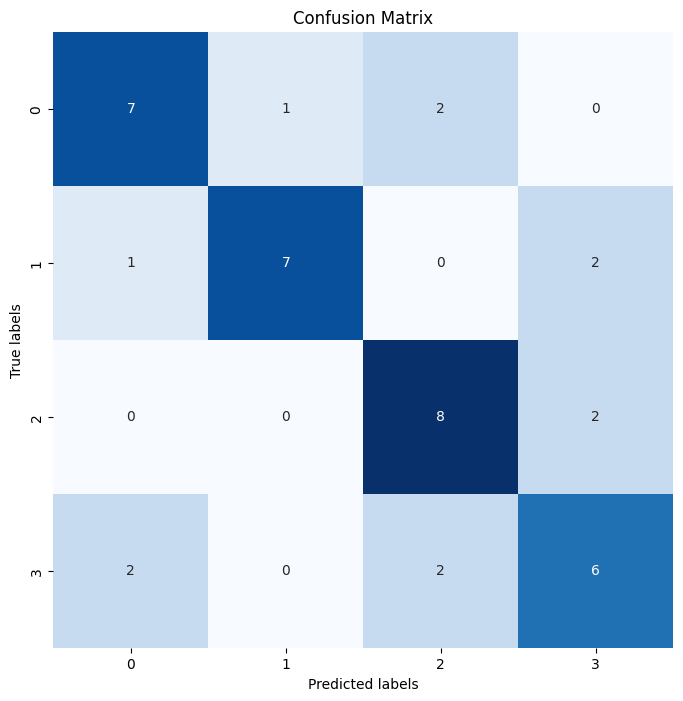

In [ ]:
# visualize the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# generate classification report
report = classification_report(numeric_labels, y_pred_labels)
print(report)

              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.88      0.70      0.78        10
           2       0.67      0.80      0.73        10
           3       0.60      0.60      0.60        10

    accuracy                           0.70        40
   macro avg       0.71      0.70      0.70        40
weighted avg       0.71      0.70      0.70        40



In [ ]:
def plot_training_history(history):
    # get the training and validation metrics
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # plot accuracy
    plt.figure(figsize=(6, 4))
    plt.plot(accuracy, 'g', label='Training Accuracy')
    plt.plot(val_accuracy, 'b', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.show()

    # plot loss
    plt.figure(figsize=(6, 4))
    plt.plot(loss, 'g', label='Training Loss')
    plt.plot(val_loss, 'b', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

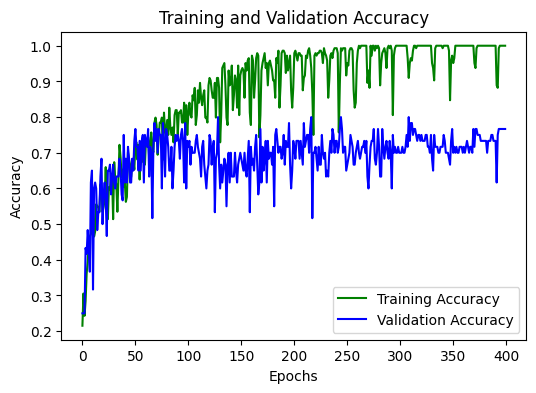

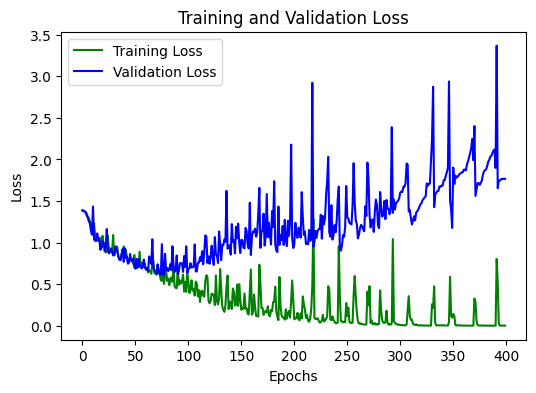

In [ ]:
plot_training_history(history)

# Predict and Recommendation

In [ ]:
from PIL import Image

In [ ]:
def get_input(image_path):
    image = get_image(image_path)
    image = get_colors(image, 3)
    image = np.expand_dims(image, axis=0)  # an extra dimension for batch size
    return image

In [ ]:
# predict function for inference
def predict(model, img):
    predictions = model.predict(img)
    predicted_class = class_names[np.argmax(predictions[0])]

    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
def generate_custom_paragraph(predicted_label):

    default = '\nSaran lainnya: \n 1. Pertahankan pH larutan nutrisi hidroponik (antara 5.5 hingga 6.5). \n 2. Pastikan sistem hidroponik memiliki sirkulasi air yang baik \n 3. Gunakan sistem filtrasi air jika diperlukan.'
    # Define a mapping of labels to custom paragraphs
    mapping = { # tinggal revisi paragraf
        'FN': 'Selada yang  memiliki cukup nutrisi dapat mengalami pertumbuhan yang baik dan warna daun yang sehat. \n Dalam kondisi ini, tidak terdapat kekurangan nutrisi spesifik yang perlu diatasi. \n' + default,
        '-N': 'Selada yang kekurangan nitrogen dapat mengalami pertumbuhan terhambat, warna daun kekuningan, \n serta kualitas tanaman yang rendah. Untuk mengatasi masalah ini, disarankan untuk meningkatkan \n pemupukan nitrogen menggunakan pupuk yang kaya akan nutrisi tersebut. \n 1. Pupuk ZA Petro \n 2. KNO3 Crystal \n 3. Mutiara Sprinter Pupuk NPK 20-10-10 \n' + default,
        '-P': 'Selada yang kekurangan fosfor dapat mengalami pertumbuhan terhambat, perkembangan akar yang terganggu, \n warna daun yang keunguan dan pucat, serta kualitas tanaman yang rendah. Untuk mengatasi masalah ini, \n disarankan untuk meningkatkan pemupukan fosfor menggunakan pupuk yang kaya akan nutrisi tersebut. \n 1. Pupuk DAP ULTRADAP pak tani \n 2. Pupuk MAP MerokeMAP \n 3. Pupuk TSP MerokeTSP \n' + default,
        '-K': 'Selada yang kekurangan kalium dapat mengalami pertumbuhan terhambat, perkembangan akar yang terganggu, \n warna daun kecoklatan, serta resistensi terhadap penyakit yang rendah. Untuk mengatasi masalah ini, \n disarankan untuk meningkatkan pemupukan menggunakan pupuk yang kaya akan nutrisi tersebut. \n 1. Pupuk KNO3 Crystal \n 2. Pupuk KCL MerokeMOP \n 3. Pupuk ZK Cap Goldenmax \n' + default,
    }

    # Get the custom paragraph based on the predicted label
    custom_paragraph = mapping.get(predicted_label, 'Tidak ada rekomendasi untuk saat ini')

    return custom_paragraph

1/1 [==============================] - 0s 70ms/step


(-0.5, 1022.5, 1004.5, -0.5)

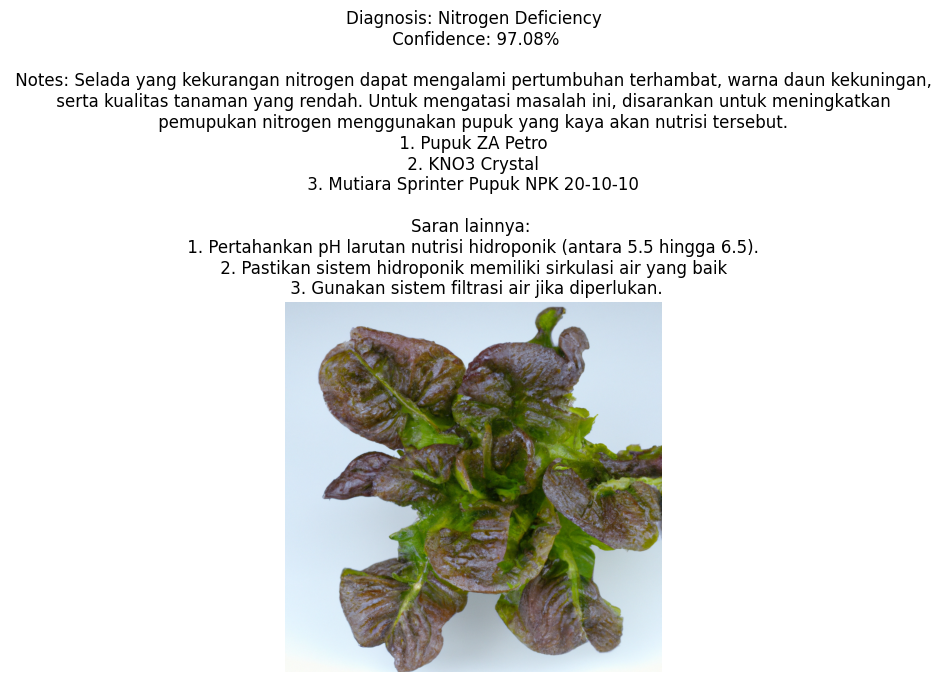

In [ ]:
# get a sample image
image = get_image('/content/drive/MyDrive/bangkit/dataset_bilal/lettuce/-P/-P (38).png')

# predict the image
input_image = get_input(image)
predicted_class, confidence = predict(model, input_image)

# convert predicted class
label_mapping = {"FN": "Fully Nutritional", "-N": "Nitrogen Deficiency", "-P": "Phosporus Deficiency", "-K": "Kalium Deficiency"}
predicted_class_mapped = label_mapping[predicted_class]

plt.imshow(image)
plt.title(f"Diagnosis: {predicted_class_mapped}\n Confidence: {confidence}%\n\n Notes: {generate_custom_paragraph(predicted_class)}")
plt.axis("off")

# Save Keras Model

In [ ]:
import tensorflow as tf

In [ ]:
# saved to .h5 format
model.save(base_dir + '/lettuce_model.h5')
model = tf.keras.models.load_model(base_dir + '/lettuce_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# saved to tensorflow
export_dir = base_dir + '/saved_model_capstone'
tf.saved_model.save(model, export_dir=export_dir)

In [ ]:
mode = ""

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [ ]:
# convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.optimizations = [optimization]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]

# disable experimental lowering of tensor list ops
converter.experimental_lower_tensor_list_ops = False

tflite_model = converter.convert()

In [ ]:
# save the TensorFlow Lite model
with open('lettuce_model.tflite', 'wb') as f:
    f.write(tflite_model)